# Uniper Account Classification

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions
import pickle
from datetime import date
from pathlib import Path
import zipfile
from zipfile import ZipFile
import dill as pkl
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

TODAY = date.today().strftime("%Y%m%d")
CLIENT = "Uniper"
MIN_NUM_OF_SAMPLES = 5
COUNTRY = 'DE'  # possible choices: DE, UK, AT, SE, UBX
SAVE_CLFS = True
PREDICTIONS_EXCEL = False
RES_DIR = Path(f"./retraining_october21/{COUNTRY.lower()}")
SCAN_ID_COL = "gl_document_scan_id"  # document identifier col used when reducing
                                     # global df to relevant examples for attribute

In [2]:
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [21]:
# %load training_utils.py
"""This file contains helper functionality to train/evaluate models
   and create reports"""

import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions


def reduce_to_relevant(df: DataFrame, col: str, min_num_samples: int) -> DataFrame:
    """Reduces df to instances with values in col that appear at least
       min_num_samples times and returns reduced df.

    Args:
        df (DataFrame): Input DataFrame.
        col (str): Name of the column that holds the feature of interest.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'col'
            that appear more than 'min_num_samples' times.

    """
    # find rows for values that appear at least min_num_samples times
    relevant = [x for x in df[col].value_counts().index
                if df[col].value_counts()[x] >= min_num_samples]
    # create boolean mask
    mask = [(x in relevant) for x in df[col]]

    print(
        f"Reduced to {len(df[mask])} samples from {len(relevant)} relevant classes. (N={min_num_samples})"
    )

    return df[mask]


def get_reduced_df(
        df: DataFrame,
        feature_col: str,
        scan_id_col: str,
        min_num_samples: int) -> DataFrame:
    """Drops duplicates and reduces df to relevant examples that appear
       at least min_num_samples times and are unambiguous.

    Args:
        df (DataFrame): Input DataFrame.
        feature_col (str): Name of the column that holds the feature of interest.
        scan_id_col (str): Name of the column that holds the unique
            document identifier.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'feature_col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'feature_col'
            that appear more than 'min_num_samples' times and are unambiguous.

    """
    # keep only documents with unambiguous value for this col
    df_ = df.drop_duplicates(subset=[scan_id_col, feature_col])\
            .groupby(scan_id_col)\
            .filter(lambda x: len(x) == 1)

    return reduce_to_relevant(df_, feature_col, min_num_samples)


def split_for_target_col(df, col, test_size=0.2, random_state=666):
    """
    Performs train test split with specified col as target variable.
    Returns: X_train, X_test, y_train, y_test
    """
    return train_test_split(
        df,
        df[col],
        test_size=test_size,
        random_state=random_state
    )


def _get_top_n_results_with_confs(
        clazzes: Sequence[str],
        probs: List[float],
        n: int = 1) -> List[Tuple[str, float]]:
    """Constructs list of (class, proba) tuples for top n results.

    Args:
        clazzes (Sequence[str]): Sequence of class names as stored in
            clf.classes_ attribute of sklearn classifier.
        probs (List[float]): List with probabilities for each class in clazzes.
        n (int): Number of most probable results to return. Defaults to 1.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for top n results.

    """
    return sorted(
        zip(clazzes, probs),
        key=lambda x: x[1],
        reverse=True
    )[:n]


def get_results_for_target(
        target_clf: Any,
        df: DataFrame) -> List[Tuple[str, float]]:
    """Computes predictions with provided classifier on DataFrame df.

    Args:
        target_clf (Any): Sklearn classifier that offers 'predict_proba()'.
        df (DataFrame): Input DataFrame as expected by 'target_clf'.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for
            instances in df.

    """
    probs = target_clf.predict_proba(df)
    clazzes = target_clf.classes_
    results = []
    for prob_list in probs:
        results.append(_get_top_n_results_with_confs(clazzes, prob_list)[0])
    return results


def _get_text_col_from_df(df: DataFrame):
    return df['text']


def save_clf_to_disk(
        clf,
        attribute_name: str,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int,
        add_zip=True) -> None:

    # safe to pkl with full info in file name
    pkl_path = folder / f"{date}_{client}_clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl"
    with open(pkl_path, 'wb') as file:
        pkl.dump(clf, file)

    if add_zip:
        # create zip with non changing name for easy deployment
        zip_path = folder / f"clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl.zip"
        with ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as file:
            # second argument avoids recreation of folder structure in zip-archive
            file.write(pkl_path, pkl_path.parts[-1])


def enrich_kw_list(kw_list):
    """Enriches keywords by replacing street names with possible synonyms. Since we demand ALL keywords to
       be found for a positive match, this function returns a list of keyword lists, one for every possible
       synonym.
    
    """
    new_kw_lists = [kw_list]
    street_synonyms = ["str.", "strasse", "straße"]
    for street_syn in street_synonyms:
        remaining_syns = [x for x in street_synonyms if x != street_syn]
        if any(street_syn in kw for kw in kw_list):
            new_kw_lists += [[kw.replace(street_syn, synonym) for kw in kw_list] for synonym in remaining_syns]
    return new_kw_lists


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tday = date.today().strftime("%A %d. %B %Y") 
print(f"Models trained on {tday} with package versions: \n")
print(f"scikit-learn: {sklearn.__version__}")
print(f"dill: {pkl.__version__}")

Models trained on Friday 04. February 2022 with package versions: 

scikit-learn: 1.0.2
dill: 0.3.4


In [6]:
# dicts used to restrict ground truth later
country_group_to_countries = {
    "DE": ["DE"],
    "SE": ["SE"],
    "AT": ["AT"],
    "UK": ["GB"],
    "UBX": ["BE", "NL", "LU"]    
}

In [11]:
with open("C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/texts_all_rt202110.pkl", "rb") as file:
    df_lume = pickle.load(file)
df_lume.drop_duplicates(inplace=True)
print(df_lume.shape)

df_ground_truth = pd.read_excel("C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/Uniper_GT_09_21.xlsx")
len(df_ground_truth)

df_ground_truth.dropna(subset=[SCAN_ID_COL], inplace=True)
df_ground_truth[SCAN_ID_COL] = df_ground_truth[SCAN_ID_COL].apply(lambda x: x.lower())

len(df_ground_truth[SCAN_ID_COL].unique())
df_merged = df_lume.merge(df_ground_truth, left_on=["filename"], right_on=[SCAN_ID_COL], how="inner")

df_merged.drop_duplicates(inplace=True)
df_merged.shape

# add left-hand zeros to gl_legal_entity_id, gl_accounts_id, gl_vendor_id
df_merged['gl_legal_entity_id'] = df_merged['gl_legal_entity_id'].apply(lambda x: str(int(x)).zfill(4))
df_merged['gl_accounts_id'] = df_merged['gl_accounts_id'].apply(lambda x: str(int(x)).zfill(10))
df_merged['gl_vendor_id'] = df_merged['gl_vendor_id'].apply(lambda x: str(int(x)).zfill(10))

# restict to respective country(group)
df = df_merged[
    df_merged['le_country_id'].isin(country_group_to_countries[COUNTRY])
]

df['le_country_id'].value_counts()

df['gl_posting_id'] = df['gl_posting_id'].apply(lambda x: str(int(x)))

dft = get_reduced_df(df, 'gl_posting_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
dft[dft['gl_posting_id'] == '50']
df[['gl_legal_entity_id', 'gl_accounts_id', 'gl_cost_center_id', 'gl_wbs_element_id', 'gl_vendor_id']]

In [18]:
with open('C:/Users/runyaoyu/Desktop/Project1101/Sebastian/RetrainingOctober2021/Daten/sc21v8.json', 'r') as file:
    mapping_json = json.load(file)

enrich_kw_list(["a", "b", "heinestrasse"])

# apply mapping if df contains any of the relevant legeal entity ids

remapped_docs = []

if any([key in df['gl_legal_entity_id'].unique() for key in mapping_json.keys()]):
    
    #print("Starting to apply remapping script...")
    
    type_to_col = {
        'psp': 'gl_wbs_element_id',
        'cc': 'gl_cost_center_id',
        None: ['gl_cost_center_id', 'gl_order_id', 'gl_wbs_element_id']
    }

    # from collections import defaultdict
    # old_vals = defaultdict(list)
    # new_vals = defaultdict(list)

    for legal_entity, mapping_list in mapping_json.items():
        for mapping in mapping_list:

            gl_acc, old_value, old_type, new_value, new_type, gl_vend, keywords = mapping

            if old_value is None:
                continue
                
            # added 20211021
            if old_type is None and new_type is None:
                continue

            # fill up with left hand zeros
            # gl account auch mit 0 füllen???
            if old_type == 'cc':
                old_value = old_value.zfill(10)
            if new_type == 'cc':
                new_value = new_value.zfill(10)
            if gl_vend is not None:
                gl_vend = gl_vend.zfill(10)

            old_col = type_to_col[old_type]
            new_col = type_to_col[new_type]

            # create filter mask
            if old_value == '*':
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc)
            else:
                #print(f"legal entity {legal_entity}, mapping {mapping}")
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc) \
                    & (df[old_col] == old_value)

            if gl_vend is not None:
                mask = mask & (df['gl_vendor_id'] == gl_vend)

            if keywords:
                kw_lists = enrich_kw_list(keywords)
                kw_mask = df['text'].apply(
                    lambda text: any([all([kw in text for kw in kws]) for kws in kw_lists])
                )
                mask = mask & kw_mask

            # set new values, override old ones if necessary
            if not df.loc[mask].empty:
                #print(f'found value {old_value} of type {old_type} for legal entity {legal_entity}')
                if old_col == new_col:
    #                 print('old_col == new_col')
                    df.loc[mask, new_col] = new_value
    #                 old_vals[legal_entity].append(old_value)
    #                 new_vals[legal_entity].append(new_value)
                else:
    #                 print('old_col != new_col')
                    df.loc[mask, old_col] = np.nan
                    df.loc[mask, new_col] = new_value
                
                if isinstance(df.loc[mask, SCAN_ID_COL], str):
                    remapped_docs.append(df.loc[mask, SCAN_ID_COL])
                else:
                    remapped_docs += list(df.loc[mask, SCAN_ID_COL])
                
    print(f"finished remapping, writing {SCAN_ID_COL} of mapped invoices to excel file")
    pd.DataFrame.from_dict({SCAN_ID_COL: list(set(remapped_docs))})\
            .to_excel(RES_DIR / f"{TODAY}_{CLIENT}_remapped_invoices.xlsx", index=False)

finished remapping, writing gl_document_scan_id of mapped invoices to excel file


In [27]:
# Runyao's update

def get_certain_class_after_vec_country(df_lume, label):
    label = label
    df_attr = get_reduced_df(df_lume, label, SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
    x_train, x_test, y_train, y_test = split_for_target_col_stratified(df_attr, label)
    vectorizer = TfidfVectorizer(max_features=20000, max_df=0.75, sublinear_tf=True,)
    X_train = x_train['text']
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test = x_test['text']
    X_test_vec = vectorizer.transform(X_test)
    return x_train, x_test, y_train, y_test, X_train_vec, X_test_vec


def split_for_target_col_stratified(df, col, test_size=0.2, random_state=42,):
    return train_test_split(df,
        df[col],
        test_size=test_size,
        random_state=random_state,
        stratify=df[col]
    )


def train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test):

    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    print(model.best_params_)
    print(model.best_score_)
    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))

    print(classification_report(y_test, y_test_pred))

    # confusion matix
    conf_train = confusion_matrix(y_train, y_train_pred)
    conf_test = confusion_matrix(y_test, y_test_pred)

    fg, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(conf_train, annot=True, fmt="d", ax=ax1)
    ax1.set(xlabel="predicted label")
    ax1.set(ylabel="actual label")
    #ax1.set_xticklabels(['0','1'])
    #ax1.set_yticklabels(['0','1'])
    ax1.set(title="Confusion Matrix for training set")

    sns.heatmap(conf_test, annot=True, fmt="d", ax=ax2)
    ax2.set(xlabel="predicted label")
    ax2.set(ylabel="actual label")
    #ax2.set_xticklabels(['0','1'])
    #ax2.set_yticklabels(['0','1'])
    ax2.set(title="Confusion Matrix for test set")


# gl_accounts_id

In [19]:
df_gl_id = get_reduced_df(df, 'gl_accounts_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)


Reduced to 28168 samples from 176 relevant classes. (N=5)


,filename,text,gl_instance_id,gl_fiscal_year,gl_header_id,gl_line_nr,gl_reference_document_nr,gl_document_date,gl_doc_currency,gl_vendor_id,...,gl_original_document_source,gl_original_document_nr,gl_reference_internal_key_1,gl_document_type_key,gl_debit_credit,multiple_vendors,gl_approver,gl_document_scan_id,multiple_scans,multiple_postings
0,000d3a2c37f81eda88f70ad52d38ce1c,gedruckt auf „steinbeis innojet premiui ausge...,100,2020.0,3.200000e+09,2.0,16620731012651,2019-12-09,EUR,0002000582,...,BKPF,3.200000e+17,NaN,100VA,Debit,NaN,A40185,000d3a2c37f81eda88f70ad52d38ce1c,NaN,NaN
1,000d3a2c37f81eda88f70adcd822ee1c,el: { n 1 )) } ad l dds conferencing & caterin...,100,2020.0,3.200000e+09,2.0,DDS-19/20-1010-E,2019-12-10,EUR,0002449868,...,BKPF,3.200000e+17,NaN,100VA,Debit,NaN,A40185,000d3a2c37f81eda88f70adcd822ee1c,NaN,NaN
2,000d3a2c37f81eda88f70ab0ea394e1c,zimmermann hauschild notare lubmin-brandov ga...,100,2020.0,3.200000e+09,2.0,Z2856/0/1-2019,2019-12-11,EUR,0002053354,...,BKPF,3.200000e+17,NaN,100VA,Debit,NaN,A40185,000d3a2c37f81eda88f70ab0ea394e1c,NaN,NaN
3,000d3a2c37f81eea8cd4c4aa57e474ed,rechnung uniper global commodities se rechnun...,100,2020.0,3.200000e+09,2.0,90063731-993703,2020-01-08,EUR,0001000092,...,BKPF,3.200000e+17,NaN,100VA,Debit,NaN,A40185,000d3a2c37f81eea8cd4c4aa57e474ed,NaN,NaN
4,000d3a2c37f81eda88f70aafcad7ee1c,= as fri it til vinr fre „> bundesnetzagent...,100,2020.0,3.200000e+09,2.0,13.12.2019,2019-12-09,EUR,0001257969,...,BKPF,3.200000e+17,NaN,100VA,Debit,NaN,M21419,000d3a2c37f81eda88f70aafcad7ee1c,NaN,NaN


In [28]:
label = 'gl_accounts_id' # define label here
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

lr = LogisticRegression(random_state=1) #'C':[1, 0.95, 0.9]
parameters = {'penalty': ['none', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)

Reduced to 28168 samples from 176 relevant classes. (N=5)
Fitting 10 folds for each of 45 candidates, totalling 450 fits


# gl_legal_entity_id

In [ ]:
label = 'gl_legal_entity_id' # define label here
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

lr = LogisticRegression(random_state=1)
parameters = {'penalty': ['none', 'l2', 'elasticnet'], 'C':[1, 0.95, 0.9], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)

----------  start training for attribute: gl_legal_entity_id  ---------- 

Reduced to 33631 samples from 22 relevant classes. (N=5)
Accuracy is 0.9736881224914523.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        0037       1.00      0.98      0.99        58
        0065       1.00      1.00      1.00       358
        0301       0.96      0.99      0.97      1839
        0303       0.99      1.00      0.99      1706
        0330       0.94      0.97      0.95       374
        0362       1.00      0.94      0.97       113
        0377       1.00      0.93      0.96        28
        0601       1.00      0.98      0.99       442
        0801       0.98      0.96      0.97       945
        0806       0.98      0.89      0.93        47
        0811       1.00      0.47      0.64        17
        0821       0.98      0.98      0.98       211
        2101       0.98      0.99      0.99       262
        2111       0.99      0.97      0.98       118


C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created word report  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_legal_entity_id  ----------


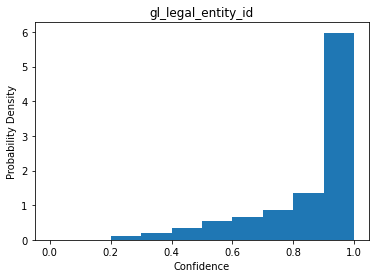

In [54]:
train_clf_and_create_reports(
    df,
    'gl_legal_entity_id',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    MIN_NUM_OF_SAMPLES,
    histogram=True,
    word_report=True,
    predictions_excel=PREDICTIONS_EXCEL,
    save_clf=SAVE_CLFS
)

# gl_tax_code_id

In [ ]:
label = 'gl_tax_code_id' # define label here
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

lr = LogisticRegression(random_state=1)
parameters = {'penalty': ['none', 'l2', 'elasticnet'], 'C':[1, 0.95, 0.9], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)

----------  start training for attribute: gl_tax_code_id  ---------- 

Reduced to 32127 samples from 31 relevant classes. (N=5)
Accuracy is 0.9097416744475568.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

          0W       1.00      0.86      0.92        14
          11       0.97      0.89      0.93        38
          51       0.90      0.99      0.94      4166
          52       0.95      0.65      0.77       655
          53       0.81      0.52      0.64       157
          54       0.00      0.00      0.00         1
          56       0.75      0.38      0.50        16
          80       0.96      0.98      0.97       525
          99       0.96      0.78      0.86       529
          A1       1.00      0.83      0.91         6
          B2       0.00      0.00      0.00         0
          C2       0.84      0.83      0.84        59
          C3       1.00      0.52      0.68        27
          C6       1.00      1.00      1.00        32
    

C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

----------  created histogram  ---------- 



C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created word report  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_tax_code_id  ----------


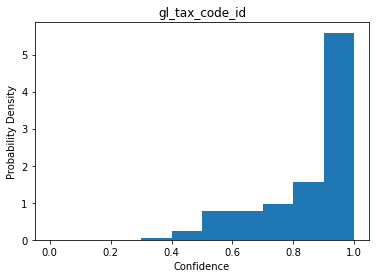

In [55]:
train_clf_and_create_reports(
    df,
    'gl_tax_code_id',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    MIN_NUM_OF_SAMPLES,
    histogram=True,
    word_report=True,
    predictions_excel=PREDICTIONS_EXCEL,
    save_clf=SAVE_CLFS
)

# gl_vendor_id

In [ ]:
label = 'gl_vendor_id' # define label here
x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

lr = LogisticRegression(random_state=1)
parameters = {'penalty': ['none', 'l2', 'elasticnet'], 'C':[1, 0.95, 0.9], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
#model.get_params().keys()
train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test)

----------  start training for attribute: gl_vendor_id  ---------- 

Reduced to 28139 samples from 876 relevant classes. (N=5)
Accuracy is 0.9792110874200426.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

  0001000007       1.00      0.80      0.89        10
  0001000008       1.00      1.00      1.00         3
  0001000074       1.00      1.00      1.00        65
  0001000075       1.00      1.00      1.00         4
  0001000085       1.00      1.00      1.00        29
  0001000089       1.00      1.00      1.00       333
  0001000092       1.00      1.00      1.00       100
  0001000275       1.00      1.00      1.00        22
  0001000281       1.00      1.00      1.00         6
  0001000282       1.00      1.00      1.00        11
  0001000283       1.00      1.00      1.00        12
  0001000284       1.00      1.00      1.00        32
  0001000305       1.00      1.00      1.00         4
  0001000538       1.00      1.00      1.00         1
  000

C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

----------  created histogram  ---------- 



C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created word report  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_vendor_id  ----------


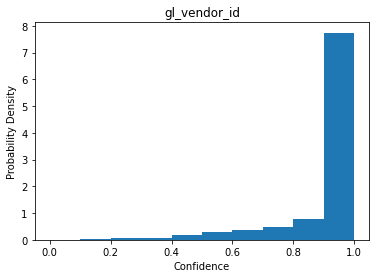

In [56]:
train_clf_and_create_reports(
    df,
    'gl_vendor_id',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    MIN_NUM_OF_SAMPLES,
    histogram=True,
    word_report=True,
    predictions_excel=PREDICTIONS_EXCEL,
    save_clf=SAVE_CLFS
)

# Train cost element classifiers per company code

## Prepare Data

In [57]:
# Prepare cost element column

df_kostenstelle = df[df['gl_cost_center_id'].notna()]
df_kostenstelle['Target'] = df_kostenstelle['gl_cost_center_id']

df_psp = df[df['gl_wbs_element_id'].notna()]
df_psp['Target'] = df_psp['gl_wbs_element_id']

df_auftrag = df[df['gl_order_id'].notna()]
df_auftrag['Target'] = df_auftrag['gl_order_id']

df_pka = pd.concat([df_auftrag,df_kostenstelle, df_psp], axis=0)
df_pka['Target'] = df_pka['Target'].apply(lambda x: str(x))

df_pka.dropna(subset=['text'], inplace=True)
df_pka.drop_duplicates(subset=['text'], inplace=True)

len(df_pka),len(df_pka['text'].unique())

<ipython-input-57-dcc3b2c8755c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kostenstelle['Target'] = df_kostenstelle['gl_cost_center_id']
<ipython-input-57-dcc3b2c8755c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_psp['Target'] = df_psp['gl_wbs_element_id']
<ipython-input-57-dcc3b2c8755c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

(31656, 31656)

In [61]:
with open(RES_DIR / f"{TODAY}_{CLIENT}_clf_gl_legal_entity_id_{COUNTRY.lower()}_N_{MIN_NUM_OF_SAMPLES}.pkl", "rb") as file:
    clf_bukr = pkl.load(file)

## Train classifiers (always uses N=1 here)

In [63]:
local_min_num = 1

for company_code in clf_bukr.classes_:
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    num_classes = len(df_cost_elem["Target"].unique())
    #print(f"company code {str(company_code).zfill(4)}: {len(df_cost_elem)} entries for {num_classes} classes")

company code 0037: 279 entries for 6 classes
company code 0065: 1721 entries for 174 classes
company code 0301: 7176 entries for 782 classes
company code 0303: 8809 entries for 1207 classes
company code 0330: 1605 entries for 107 classes
company code 0362: 563 entries for 36 classes
company code 0377: 173 entries for 23 classes
company code 0601: 2245 entries for 276 classes
company code 0801: 4789 entries for 568 classes
company code 0806: 229 entries for 20 classes
company code 0811: 53 entries for 10 classes
company code 0812: 5 entries for 1 classes
company code 0821: 1069 entries for 105 classes
company code 2101: 1321 entries for 137 classes
company code 2111: 624 entries for 57 classes
company code 3104: 172 entries for 21 classes
company code 3401: 62 entries for 1 classes
company code 3420: 279 entries for 20 classes
company code 9301: 23 entries for 9 classes
company code 9310: 187 entries for 61 classes
company code 9351: 168 entries for 21 classes
company code 9370: 104 ent

In [64]:
# this is the output used in the config file
for company_code in clf_bukr.classes_:
    print(f"cost_element_{COUNTRY.lower()}_{str(company_code).zfill(4)}" + " = "
          f"data/models/accountclassification_models/{COUNTRY.lower()}/clfs_{COUNTRY.lower()}/clf_pka_cascade_{COUNTRY.lower()}_company_code_{str(company_code).zfill(4)}_N_{local_min_num}.pkl.zip")

cost_element_de_0037 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0037_N_1.pkl.zip
cost_element_de_0065 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0065_N_1.pkl.zip
cost_element_de_0301 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0301_N_1.pkl.zip
cost_element_de_0303 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0303_N_1.pkl.zip
cost_element_de_0330 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0330_N_1.pkl.zip
cost_element_de_0362 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0362_N_1.pkl.zip
cost_element_de_0377 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0377_N_1.pkl.zip
cost_element_de_0601 = data/models/accountclassification_models/de/clfs_de/clf_pka_cascade_de_company_code_0601_N_1.pkl.zip
cost_ele

In [65]:
for company_code in clf_bukr.classes_:
    print(f"Company Code: {str(company_code).zfill(4)}" + "\n")
    # reduce dataframe to entries for fixed company code
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    
    print("Cost Element classification:")
    # reduce to relevant samples
    df_ce = reduce_to_relevant(df_cost_elem, "Target", min_num_samples=local_min_num)
    
    if df_ce.shape[0] == 0:  # do not proceed if df is empty
        print(20 * "-" + "\n")
        continue
    
    # perform train test split
    X_train, X_test, y_train, y_test = train_test_split(
    df_ce, df_ce['Target'],
    test_size = 0.2,
    random_state = 42
    )
    
    # train and evaluate model
    clf = create_model()
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test, report=False)
    
    if SAVE_CLFS:
        # create filename and subfolder (if necessary)
        fname = f"clf_pka_cascade_{COUNTRY.lower()}_company_code_{str(company_code).zfill(4)}_N_{local_min_num}.pkl"
        clfs_path = RES_DIR / f"clfs_{COUNTRY.lower()}"
        
        if not os.path.exists(clfs_path):
            os.makedirs(clfs_path)

        with open(clfs_path / fname, 'wb') as file:  
            pkl.dump(clf, file)
    
    print(20 * "-" + "\n")

Company Code: 0037

Cost Element classification:
Reduced to 279 samples from 6 relevant classes. (N=1)
Accuracy is 0.9464285714285714.
--------------------

Company Code: 0065

Cost Element classification:
Reduced to 1721 samples from 174 relevant classes. (N=1)
Accuracy is 0.7159420289855073.
--------------------

Company Code: 0301

Cost Element classification:
Reduced to 7176 samples from 782 relevant classes. (N=1)
Accuracy is 0.7277158774373259.
--------------------

Company Code: 0303

Cost Element classification:
Reduced to 8809 samples from 1207 relevant classes. (N=1)
Accuracy is 0.6174801362088536.
--------------------

Company Code: 0330

Cost Element classification:
Reduced to 1605 samples from 107 relevant classes. (N=1)
Accuracy is 0.7694704049844237.
--------------------

Company Code: 0362

Cost Element classification:
Reduced to 563 samples from 36 relevant classes. (N=1)
Accuracy is 0.8141592920353983.
--------------------

Company Code: 0377

Cost Element classificat

# gl_approver (usually N=1 is used)

----------  start training for attribute: gl_approver  ---------- 

Reduced to 33615 samples from 1011 relevant classes. (N=1)
Accuracy is 0.6642867767365759.


C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      A00548       1.00      0.33      0.50         3
      A12946       0.00      0.00      0.00         2
      A13019       0.00      0.00      0.00         1
      A14870       0.00      0.00      0.00         1
       A1550       0.50      0.33      0.40         3
      A17018       0.59      0.67      0.63        39
      A17056       1.00      0.50      0.67         2
      A17563       0.50      0.83      0.62         6
      A18091       0.71      0.26      0.38        19
      A18160       0.00      0.00      0.00         2
      A18496       0.50      1.00      0.67         1
      A21819       1.00      1.00      1.00         1
      A22646       0.61      0.94      0.74        36
      A22989       0.00      0.00      0.00         1
      A23331       0.81      0.93      0.87        14
      A23661       0.00      0.00      0.00         2
      A24501       0.00      0.00      0.00         3
  

C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created word report  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_approver  ----------


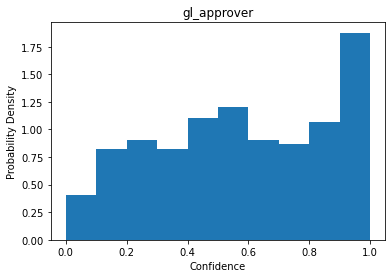

In [66]:
train_clf_and_create_reports(
    df,
    'gl_approver',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    min_num_samples=1,
    histogram=True,
    word_report=True,
    predictions_excel=PREDICTIONS_EXCEL,
    save_clf=SAVE_CLFS
)

# gl_posting_id

----------  start training for attribute: gl_posting_id  ---------- 

Reduced to 32957 samples from 2 relevant classes. (N=8)
Accuracy is 0.9863470873786407.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

          40       0.99      1.00      0.99      6298
          50       0.92      0.76      0.83       294

    accuracy                           0.99      6592
   macro avg       0.95      0.88      0.91      6592
weighted avg       0.99      0.99      0.99      6592

----------  created histogram  ---------- 

----------  created word report  ---------- 



C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_posting_id  ----------


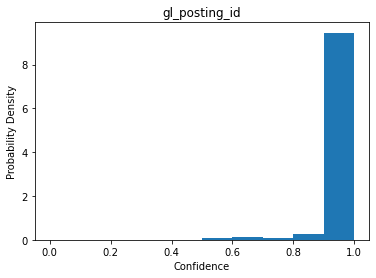

In [67]:
# train_clf_and_create_reports(
#     df,
#     'gl_posting_id',
#     SCAN_ID_COL,
#     RES_DIR,
#     TODAY,
#     CLIENT,
#     COUNTRY,
#     min_num_samples=8, # set N so that only 40 and 50 appear as classes
#     histogram=True,
#     word_report=True,
#     predictions_excel=PREDICTIONS_EXCEL,
#     save_clf=SAVE_CLFS
# )